# Set-up

## Select platform

In [1]:
PLATFORM = 'laptop' # colab or laptop

## Import dependencies

In [2]:
import altair as alt
import ast
import bz2
import IPython.display
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import pandas as pd
import pickle
import random
import scipy
import time
# from save_load import load_pickle, load_compressed, save_pickle

# To enable rendering on GitHub
# Source: https://altair-viz.github.io/user_guide/display_frontends.html
alt.renderers.enable("mimetype")

# To avoid kernel fails
# Source: https://stackoverflow.com/questions/53014306/error-15-initializing-libiomp5-dylib-but-found-libiomp5-dylib-already-initial
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
if PLATFORM == 'colab':

    # Install Hugging Face library using a shell command
    import os
    os.system("pip install transformers")

    # Mount Google Drive and CD using a shell command
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir("/content/drive/MyDrive/Data science jobs/2. Portfolio/3. NL2VIS/")

## Top level functions

In [4]:
def save_object(fname, data):
    """Pickle a file and compress it.
    Source: https://betterprogramming.pub/load-fast-load-big-with-compressed-pickles-5f311584507e
    """
    with bz2.open(fname, "wb") as f:
        pickle.dump(data, f)


def load_object(fname):
    """Load compressed pickle file
    Source: https://betterprogramming.pub/load-fast-load-big-with-compressed-pickles-5f311584507e
    """
    with bz2.open(fname, "rb") as f:
        data = pickle.load(f)
    return data
    

def validation_summary(validated_spec_df):
    """Calculates the % of problems where the first sample passes all validation tests (valid@1)
    and at least one of the k samples passes all validation tests (valid@k)
    """
    validated_spec_df = validated_spec_df.applymap(lambda x: 'Valid' if isinstance(x, dict) else x)
    
    # Valid@1
    valid_in_1 = validated_spec_df.apply(pd.Series.value_counts).apply(lambda x: x/x.sum()).transpose() * 100
    valid_in_1 = valid_in_1.iloc[0].sort_values(ascending=False)
    valid_in_1.name = 'Valid@1'
    
    # Valid@k
    is_valid = validated_spec_df == 'Valid'
    valid_in_k = is_valid.sum(axis=1) >= 1
    valid_in_k = valid_in_k.sum() / validated_spec_df.shape[0] * 100
    
    # Valid@1 & Valid@k summary
    valid_summary = pd.Series({"Valid@1": valid_in_1['Valid'],
                          "Valid@k": valid_in_k})
    
    return valid_in_1, valid_summary


def apply_logic_test(test_df, target_df, rule_func, *args):
    """Apply logic unit test (rule_func) to generated (test) specifications
    """
    output = {}
    for col, row_result in test_df.to_dict().items():
        col_output = {col: {}}

        for row, result in row_result.items():
            if isinstance(result, dict):
                col_output[col].update(
                    {row: rule_func(result, target_df, row, col, *args)})
            else:
                col_output[col].update({row: result})

        output.update(col_output)
    return pd.DataFrame.from_dict(output)


def data_source_rule(test_spec, target_df, row, column):
    """Compare data source of a generated (test) vega-lite specification to 
    a target specification.
    """
    return test_spec.get('data').get('url') == target_df.iloc[row, column]['data']['url']


def mark_type_rule(test_spec, target_df, row, column):
    """Compare mark type of a generated (test) vega-lite specification to 
    a target specification.
    """
    if 'mark' in target_df.iloc[row, column] and 'mark' in test_spec:
        return test_spec.get('mark').get('type') == target_df.iloc[row, column]['mark']['type']

    elif 'mark' not in target_df.iloc[row, column] and 'mark' not in test_spec:
        return test_spec['hconcat'][0].get('mark') == target_df.iloc[row, column]['hconcat'][0]['mark']

    else:
        return 1 == 2


def channel_rule(test_spec, target_df, row, column, *args):
    """Compare chosen channel of a generated (test) vega-lite specification to 
    a target specification.
    """
    relevant_channels, relevant_keys = args

    # Create a set of relevant values for the chosen channels
    if 'encoding' in test_spec:
        test_spec_values = {outer_key:
                            {inner_key: inner_value for inner_key, inner_value in outer_value.items() if inner_key in relevant_keys
                            }
                            for outer_key, outer_value in test_spec['encoding'].items() if outer_key in relevant_channels
                           }
    elif 'hconcat' in test_spec:
        test_spec_values = {outer_key: 
                            {inner_key: inner_value for inner_key, inner_value in outer_value.items() if inner_key in relevant_keys
                            }
                            for outer_key, outer_value in test_spec['hconcat'][0]['encoding'].items() if outer_key in relevant_channels
                           }
    else: test_spec_values = {}

    if 'encoding' in target_df.iloc[row, column]:
        target_spec_values = {outer_key:
                              {inner_key: inner_value for inner_key, inner_value in outer_value.items() if inner_key in relevant_keys
                              }
                              for outer_key, outer_value in target_df.iloc[row, column]['encoding'].items() if outer_key in relevant_channels
                             }
    else:
        target_spec_values = {outer_key:
                              {inner_key: inner_value for inner_key, inner_value in outer_value.items() if inner_key in relevant_keys
                              }
                              for outer_key, outer_value in target_df.iloc[row, column]['hconcat'][0]['encoding'].items() if outer_key in relevant_channels
                             }

    # Replace any 'mean' values for aggregate with 'average'
    for outer_key, outer_value in target_spec_values.items():
        for inner_key, inner_value in outer_value.items():
            if inner_value == 'mean':
                target_spec_values[outer_key][inner_key] = 'average'

    for outer_key, outer_value in test_spec_values.items():
        for inner_key, inner_value in outer_value.items():
            if inner_value == 'mean':
                test_spec_values[outer_key][inner_key] = 'average'

    # Create sets containing (field, aggregation function) frozen sets
    test_spec_values = [tuple(outer_value.values())
                        for outer_key, outer_value in test_spec_values.items()
                       ]
    test_spec_values = {tuple(json.dumps(element) if isinstance(element, dict) 
                              else element for element in t) for t in test_spec_values
                       }
    test_spec_values = {frozenset(t) for t in test_spec_values}

    target_spec_values = [tuple(outer_value.values())
                          for outer_key, outer_value in target_spec_values.items()
                         ]
    target_spec_values = {tuple(json.dumps(element) if isinstance(element, dict) 
                                else element for element in t) for t in target_spec_values
                         }
    target_spec_values = {frozenset(t) for t in target_spec_values}

    # Remove field in (field, aggregate function) frozen set if the aggregate function is count
    if frozenset({'count'}) in target_spec_values:
        test_spec_values = set([frozenset({'count'}) if 'count' in s else s
                                for s in list(test_spec_values)
                               ])

    # Remove aggregate function in (field, aggregate function) frozen set if the aggregate function is None
    test_spec_values = [[v for v in list(s) if v is not None
                        ]
                        for s in list(test_spec_values)
                       ]
    test_spec_values = set([frozenset(s) for s in test_spec_values])

    target_spec_values = [[v for v in list(s) if v is not None
                          ]
                          for s in list(target_spec_values)
                         ]
    target_spec_values = set([frozenset(s) for s in target_spec_values])

    return test_spec_values == target_spec_values


def unit_test_summary(has_passed_df):
    """ Calculates pass@1 and pass@k given the boolean output of unit test(s).
    """
    pass_in_1 = has_passed_df.apply(pd.Series.value_counts).apply(
        lambda x: x/x.sum()).transpose() * 100
    pass_in_1 = pass_in_1.iloc[0].sort_values(ascending=False)
    pass_in_1.rename(index={True: 'Pass', False: 'Fail'}, inplace=True)
    pass_in_1.name = 'pass@1'

    has_passed_in_k = has_passed_df == True
    has_passed_in_k = has_passed_in_k.sum(axis=1) >= 1
    pass_in_k = has_passed_in_k.sum() / has_passed_in_k.shape[0] * 100

    # pass@1 & pass@k summary
    pass_summary = pd.Series({"pass@1": pass_in_1['Pass'],
                              "pass@k": pass_in_k})

    return pass_in_1, pass_in_k, pass_summary


def all_tests_summary(unit_test_outputs):
    """Calculates overall pass@1 and pass@k using the boolean output of multiple unit tests.
    It does this in two steps.
    1) A flag indicating whether a specification has passed all unit tests is inserted.
    2) All boolean unit test outputs are compared to the first test. Returns True if all True.
    Source: https://towardsdatascience.com/python-tricks-check-multiple-variables-against-single-value-18a4d98d79f4
    """
    unit_test_outputs = [is_valid.applymap(lambda x: x if x == True else np.nan)
                        for is_valid in unit_test_outputs]
    
    has_passed_all = unit_test_outputs[0].copy(deep=True)
    for row in range(unit_test_outputs[0].shape[0]):
        for col in range(unit_test_outputs[0].shape[1]):
            has_passed_all.iloc[row, col] = all(unit_test_outputs[0].iloc[row, col] == x 
                                                for x in [is_valid.iloc[row, col] 
                                                          for is_valid in unit_test_outputs
                                                         ]
                                               )
    return has_passed_all, unit_test_summary(has_passed_all)


def pass1_split(validated_outputs, has_passed_all, input_prompts, split):
    """ Calculates pass@1 (using the first sample) after splitting specifications
    by mark type or data source.
    """
    has_passed_all = pd.concat([has_passed_all, input_prompts[split]], axis=1)
    split_counts = has_passed_all.groupby([split, 0]).size().unstack(fill_value=0)
    split_counts = split_counts.rename({True: "Pass", False: "Fail"}, axis=1)
    total_count = split_counts.sum(axis=1)
    split_rates = split_counts.div(total_count, axis=0).add_suffix(" %")
    
    return pd.concat([split_rates, split_counts, total_count.rename('Total')], axis=1)

## Parameters

### Model parameters

In [5]:
DECODE_STRATEGY = "top_p"
MODEL_TYPE = "gpt-neo-125M"
INPUT_PROMPTS = 'ID_3shot_test_set'
MODEL_OUTPUT = 'ID_3shot_test_set-gpt-neo-125M-20230830-114246'
NUM_OUTPUTS = 10

### File parameters

In [6]:
TIME_STRING = time.strftime("%Y%m%d-%H%M%S")
OUTPUT_FILENAME = MODEL_OUTPUT + '_validated'

if PLATFORM == 'colab':
    FILE_DIRECTORY = '/content/drive/MyDrive/Data science jobs/2. Portfolio/3. NL2VIS/'

elif PLATFORM == 'hpc':
    FILE_DIRECTORY = "/mnt/scratch/users/adbz866/"

elif PLATFORM == 'laptop':
    FILE_DIRECTORY = 'C:/Users/billy/OneDrive/Documents/Python Scripts/1. Portfolio/1. NL2VIS/data/cleaned/'

In [7]:
print("Time:", TIME_STRING)
print("File directory:", FILE_DIRECTORY)
print("\n")
print("Platform:", PLATFORM)
print("Model:", MODEL_TYPE)
print("Input prompts:", INPUT_PROMPTS)
print("Model output:", MODEL_OUTPUT)
print("Decoding strategy:", DECODE_STRATEGY)

Time: 20230901-144004
File directory: C:/Users/billy/OneDrive/Documents/Python Scripts/1. Portfolio/1. NL2VIS/data/cleaned/


Platform: laptop
Model: gpt-neo-125M
Input prompts: ID_3shot_test_set
Model output: ID_3shot_test_set-gpt-neo-125M-20230830-114246
Decoding strategy: top_p


# Import data

In [8]:
# Input prompts
with open(FILE_DIRECTORY + INPUT_PROMPTS + '.pickle', 'rb') as f:
    input_prompts = pickle.load(f)

# Decoded generated sequences
model_output = load_object(FILE_DIRECTORY + MODEL_OUTPUT + '_results')

# Validated generated sequences
validated_output = load_object(FILE_DIRECTORY + MODEL_OUTPUT + '_results_validated')

# Pre-processing

In [9]:
# Create target spec df
target_df = input_prompts[['spec']].copy(deep=True)
target_df['spec'] = target_df['spec'].apply(lambda x: ast.literal_eval(x))
target_df = pd.concat([target_df for n in range(NUM_OUTPUTS)], axis=1, ignore_index=True)

# Create model output df
output_df = model_output['Decoded sequences']
output_df = pd.DataFrame(output_df, columns = list(range(NUM_OUTPUTS)))

# Create validated output df
validated_output_df = validated_output['Validated spec']
validated_output_df = pd.DataFrame(validated_output_df, columns = list(range(NUM_OUTPUTS)))

# Evaluation
Two evaluation metrics are crucial to the assessment of model performance: valid@k and pass@k. 

* Valid@k represents the validation rate with k samples. For example, valid@1 would represent the
fraction of problems for which the model generated a valid Vega-Lite specification with 1 sample.

* Pass@k represents the pass rate with k samples. Where pass@1 would represent the fraction of problems for which the model generated a Vega-Lite specification that passed logical unit test(s) with 1 sample.

## Validation
* Validation rates are determined in 5_validate_outputs.ipynb

    Note: An output is classified as valid if it has a valid Vega-Lite schema.

In [10]:
valid_in_1, valid_in_k = validation_summary(validated_output_df)
print(valid_in_k)

Valid@1    93.75
Valid@k    96.25
dtype: float64


## Logic unit tests
* A set of match based logical tests are used to assess the relevance of valid Vega-Lite specifications.
* All tests involve comparing a generated specification to the original (NL command, Vega-Lite specification) pair found in the corpus. A logic error is 
raised if a test fails.

<img src="figures/logical_tests.png" align="left" width="400" />

## Data source
["*Vega-Lite’s data property describes the visualization’s data source as part of the specification, which can be either inline data (values) or a URL from which to load the data (url).*"](https://vega.github.io/vega-lite/docs/data.html)

In [11]:
is_valid_dsource = apply_logic_test(validated_output_df, target_df, data_source_rule)
dsource_pass1, _, _  = unit_test_summary(is_valid_dsource)
print(dsource_pass1)

Pass                93.750
Validation error     4.375
Syntax error         1.875
Name: pass@1, dtype: float64


## Mark type
["*Marks are the basic visual building block of a visualization. They provide basic shapes whose properties (such as position, size, and color) can be used to visually encode data, either from a data field, or a constant value. The mark property of a single view specification can either be (1) a string describing a mark type or (2) a mark definition object.*"](https://vega.github.io/vega-lite/docs/mark.html)

In [12]:
is_valid_mtype = apply_logic_test(validated_output_df, target_df, mark_type_rule)
mtype_pass1, _, _  = unit_test_summary(is_valid_mtype)
print(mtype_pass1)

Pass                90.000
Validation error     4.375
Fail                 3.750
Syntax error         1.875
Name: pass@1, dtype: float64


## Data transformations
["*Data transformations in Vega-Lite are described via either view-level transforms (the transform property) or field transforms inside encoding (bin, timeUnit, aggregate, sort, and stack)*"](https://vega.github.io/vega-lite/docs/transform.html)

### Position channels

In [13]:
is_valid_pchannel = apply_logic_test(validated_output_df, target_df, channel_rule, ['x', 'y'], ['field', 'aggregate'])
pchannel_pass1, _, _  = unit_test_summary(is_valid_pchannel)
print(pchannel_pass1)

Pass                79.375
Fail                14.375
Validation error     4.375
Syntax error         1.875
Name: pass@1, dtype: float64


### Facet channels

In [14]:
is_valid_facet = apply_logic_test(validated_output_df, target_df, channel_rule, ['facet', 'row', 'column'], ['field', 'aggregate'])
facet_pass1, _, _  = unit_test_summary(is_valid_facet)
print(facet_pass1)

Pass                86.875
Fail                 6.875
Validation error     4.375
Syntax error         1.875
Name: pass@1, dtype: float64


### Mark properties

In [15]:
is_valid_mark_property = apply_logic_test(validated_output_df, target_df, channel_rule, ['color'], ['field', 'aggregate'])
mark_property_pass1, _, _  = unit_test_summary(is_valid_mark_property)
print(mark_property_pass1)

Pass                83.125
Fail                10.625
Validation error     4.375
Syntax error         1.875
Name: pass@1, dtype: float64


### Detail properties

In [16]:
is_valid_detail = apply_logic_test(validated_output_df, target_df, channel_rule, ['detail'], ['field', 'aggregate'])
detail_pass1, _, _  = unit_test_summary(is_valid_detail)
print(detail_pass1)

Pass                93.750
Validation error     4.375
Syntax error         1.875
Name: pass@1, dtype: float64


## Compare unit test outcomes

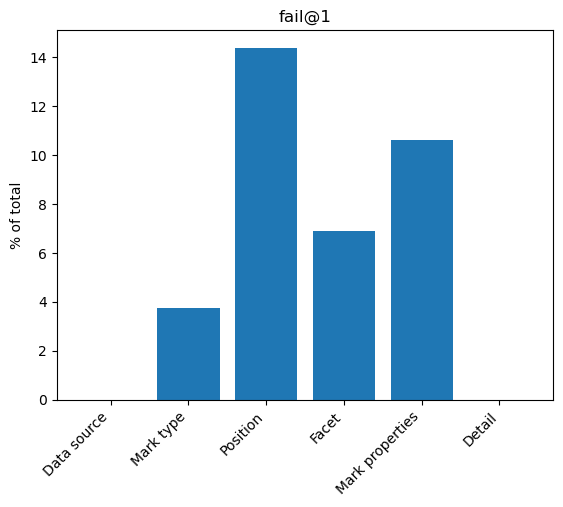

In [17]:
results = [dsource_pass1, mtype_pass1, pchannel_pass1, facet_pass1, mark_property_pass1, detail_pass1]
X = ['Data source', 'Mark type', 'Position', 'Facet', 'Mark properties', 'Detail']
Y = []     
for summary in results:
    try:
        Y.append(summary['Fail'])
    except KeyError:
        Y.append(0)

fig, axes = plt.subplots(nrows=1, ncols=1)
axes.bar(X, Y)
axes.xaxis.set_ticks(X)
axes.set_xticklabels(labels=X, rotation=45, ha='right')
axes.set_ylabel('% of total')
axes.set_title('fail@1');

# Overall pass rate
* The overall pass rate indicates the proportion of problems which passed all logic unit tests with one or k samples.

In [18]:
# pass@1
unit_test_outputs = [is_valid_dsource,
                     is_valid_mtype,
                     is_valid_pchannel,
                     is_valid_facet,
                     is_valid_mark_property,
                     is_valid_detail]

has_passed_all, (overall_pass1, overall_passk, overall_summary) = all_tests_summary(unit_test_outputs)
print(overall_pass1)

Pass    71.875
Fail    28.125
Name: pass@1, dtype: float64


pass@1    71.875
pass@k    75.625
dtype: float64




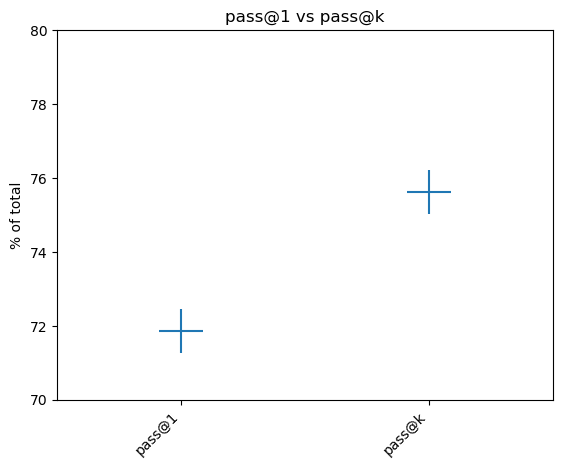

In [19]:
# pass@k
print(overall_summary)
print("\n")
fig, axes = plt.subplots(nrows=1, ncols=1)
axes.scatter(overall_summary.index, overall_summary.values, s=1000, marker='+')

axes.set_ylim([70, 80])
axes.set_xlim([-0.5, 1.5])
axes.xaxis.set_ticks(overall_summary.index)
axes.set_xticklabels(labels=overall_summary.index, rotation=45, ha='right')
axes.set_ylabel('% of total')
axes.set_title('pass@1 vs pass@k');

# Pass@1 breakdown
* Pass@1 is broken down by mark type and data source below.

## By mark type

In [20]:
pass1_split(validated_output_df, has_passed_all, input_prompts, 'markType')

,Fail %,Pass %,Fail,Pass,Total
markType,,,,,
area,1.000000,0.000000,1,0,1
bar,0.325301,0.674699,27,56,83
line,0.160000,0.840000,4,21,25
point,0.240000,0.760000,12,38,50
tick,1.000000,0.000000,1,0,1


## By data source

In [21]:
pass1_split(validated_output_df, has_passed_all, input_prompts, 'dataset')

,Fail %,Pass %,Fail,Pass,Total
dataset,,,,,
cars,0.192982,0.807018,11,46,57
euro,1.000000,0.000000,2,0,2
movies,0.214286,0.785714,12,44,56
superstore,0.444444,0.555556,20,25,45


# Render passed visualisations
* A random sample of visualisation which passed all unit tests is shown below.

histogram of Running Time


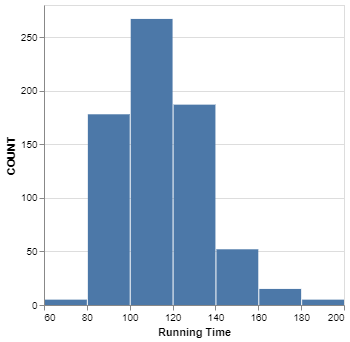

scatter plot of production budget vs worldwide gross, colored by genre


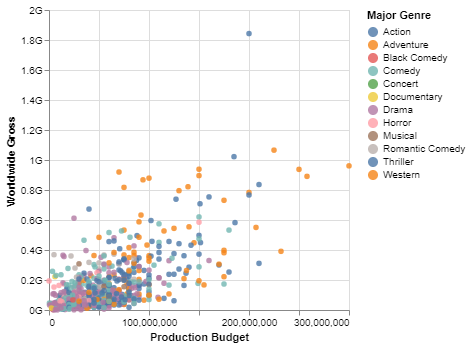

What creative type of movie had the highest production budget for each content rating?


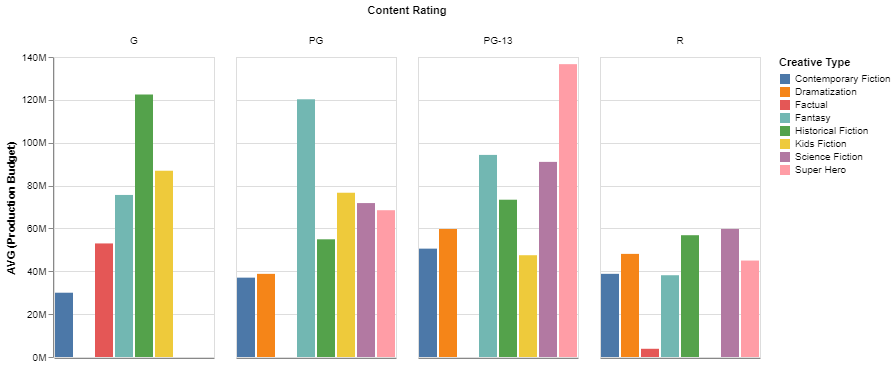

Show correlation between sales and profit


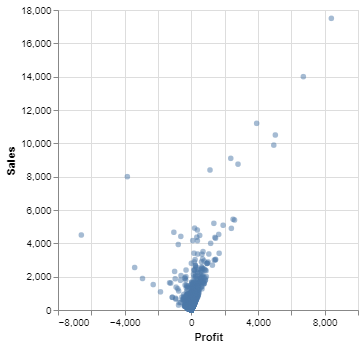

Cylinders count bar chart Color by origin


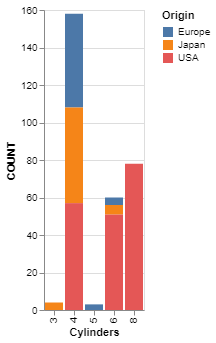

In [22]:
prompts = pd.concat([input_prompts['query'] for col in range(10)], axis=1)
prompts.columns = list(range(10))
prompts = pd.Series(prompts.to_numpy().flatten())

has_passed_all = pd.Series(has_passed_all.to_numpy().flatten())
passed_specs = pd.Series(validated_output_df.to_numpy().flatten())
passed_specs = passed_specs[has_passed_all]

random.seed(5)
samples = random.sample(passed_specs.index.tolist(), 5)
for index in samples:
  print(prompts[index])
  chart = alt.Chart(**passed_specs[index])
  chart.display()